<a href="https://colab.research.google.com/github/Veena24-hub/Intern-Phase-1/blob/main/FinBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Minimal dependencies

!pip install -q transformers datasets accelerate scikit-learn matplotlib seaborn pandas tqdm


In [2]:
# Imports & settings

import os
import time
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [3]:
# Config: models to evaluate & other params

MODELS = {
    "prosus_finbert": "ProsusAI/finbert",
    "finbert_tone": "yiyanghkust/finbert-tone",
    "stock_ft_b = dogruer": "dogruermikail/bert-fine-tuned-stock-sentiment-uncased",
    # if you want an extra baseline, uncomment:
    # "baseline": "cardiffnlp/twitter-roberta-base-sentiment"
}
# (If you want different IDs, replace strings above.)
BATCH_SIZE = 32
MAX_LENGTH = 256  # adjust if you process long news articles
DEVICE = 0  # GPU device ID for pipeline (use -1 for CPU)


In [6]:
# Loading CSV dataset

DATA = "/content/all-data.csv"
df = pd.read_csv(DATA, encoding='latin-1')
print("Loaded", len(df), "rows. Columns:", df.columns.tolist())
df.head()

Loaded 4845 rows. Columns: ['neutral', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .']


,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [7]:
# Renaming columns

df.columns = ['label', 'text']
print("Renamed columns:", df.columns.tolist())
display(df.head())

Renamed columns: ['label', 'text']


,label,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [8]:
# Basic column normalization
# Expecting: text, label (pos/neg/neutral or 1/0/-1), ticker, date
# Try to infer.

if 'text' not in df.columns:
    # heuristics
    for c in ['content','body','headline','article','tweet','sentence']:
        if c in df.columns:
            df.rename(columns={c:'text'}, inplace=True)
            break

if 'label' not in df.columns:
    # attempt to find a label column
    for c in ['sentiment','tone','label_pred','y']:
        if c in df.columns:
            df.rename(columns={c:'label'}, inplace=True)
            break

# Standardize labels to strings: "positive"/"negative"/"neutral"
def normalize_label(x):
    if pd.isna(x): return None
    s = str(x).lower().strip()
    if s in ['1','pos','positive','p','bullish','buy','up']: return 'positive'
    if s in ['-1','neg','negative','n','bearish','sell','down']: return 'negative'
    if s in ['0','neu','neutral','mixed','none','0.0']: return 'neutral'
    return s

if 'label' in df.columns:
    df['label'] = df['label'].apply(normalize_label)

print("Label value counts:\n", df['label'].value_counts(dropna=False))

Label value counts:
 label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


In [9]:
# Function to evaluate a single model via HF pipeline

def load_pipeline(model_id, device=DEVICE):
    print("Loading", model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id)
    pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=False, device=device)
    return pipe

def predict_with_pipeline(pipe, texts, batch_size=BATCH_SIZE):
    preds = []
    times = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t0 = time.time()
        out = pipe(batch, truncation=True, max_length=MAX_LENGTH)
        t1 = time.time()
        elapsed = t1 - t0
        times.append((len(batch), elapsed))
        # normalize output to label strings
        for o in out:
            label = o['label'].lower()
            # many models prefix labels like "LABEL_0" or "negative"
            if label.startswith("label_"):
                # try mapping by logits order isn't reliable here unless we inspect model.config.id2label
                label = label
            preds.append((label, o.get('score', None)))
    # compute throughput
    total_tokens = sum([c for c,_ in times])
    total_time = sum([t for _,t in times])
    throughput = total_tokens / total_time if total_time>0 else None
    return preds, times, throughput


In [10]:
# Helper to map HF model labels to standard positive/neutral/negative via model.config.id2label

def canonicalize_preds(model, raw_preds):
    # model.config.id2label usually exists
    id2lab = getattr(model.config, "id2label", None)
    out = []
    for label, score in raw_preds:
        # if label like 'LABEL_0', try to map
        lab = label
        if label.startswith("label_") and id2lab:
            try:
                # extract index
                idx = int(label.split("_")[-1])
                lab = id2lab.get(idx, lab)
            except:
                lab = label
        # normalize textual forms
        lab = lab.lower()
        if 'pos' in lab: lab = 'positive'
        elif 'neg' in lab: lab = 'negative'
        elif 'neu' in lab or 'neutral' in lab: lab = 'neutral'
        out.append((lab, score))
    return out


In [11]:
# Evaluating models and collecting metrics

results = {}
texts = df['text'].astype(str).tolist()
true_labels = df['label'].tolist() if 'label' in df.columns else None

for name, model_id in MODELS.items():
    try:
        pipe = load_pipeline(model_id)
    except Exception as e:
        print(f"Failed to load {model_id}: {e}")
        continue

    # run inference
    raw_preds, times, throughput = predict_with_pipeline(pipe, texts, batch_size=BATCH_SIZE)
    # canonicalize using model object
    canonical = canonicalize_preds(pipe.model, raw_preds)
    pred_labels = [p for p,_ in canonical]

    # compute metrics if ground truth exists
    metrics = {}
    if true_labels is not None:
        # filter out missing labels
        valid_idx = [i for i,lab in enumerate(true_labels) if lab in ('positive','negative','neutral')]
        y_true = [true_labels[i] for i in valid_idx]
        y_pred = [pred_labels[i] for i in valid_idx]
        acc = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=['positive','negative','neutral'], average=None)
        per_class = dict(zip(['positive','negative','neutral'], zip(p,r,f1)))
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        metrics = {
            'accuracy': acc,
            'per_class': per_class,
            'macro_p': macro_p, 'macro_r': macro_r, 'macro_f1': macro_f1,
            'confusion_matrix': confusion_matrix(y_true, y_pred, labels=['positive','negative','neutral']).tolist()
        }

    results[name] = {
        'model_id': model_id,
        'throughput_texts_per_sec': throughput,
        'times': times,
        'pred_labels': pred_labels,
        'scores': [s for _,s in canonical],
        'metrics': metrics
    }
    print(f"Completed {name}. Throughput {throughput:.2f} texts/sec. Accuracy(if available): {metrics.get('accuracy')}")


Loading ProsusAI/finbert


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Completed prosus_finbert. Throughput 112.88 texts/sec. Accuracy(if available): 0.8893704850361197
Loading yiyanghkust/finbert-tone


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Completed finbert_tone. Throughput 114.94 texts/sec. Accuracy(if available): 0.7925696594427245
Loading dogruermikail/bert-fine-tuned-stock-sentiment-uncased


tokenizer_config.json:   0%|          | 0.00/404 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

Failed to load dogruermikail/bert-fine-tuned-stock-sentiment-uncased: dogruermikail/bert-fine-tuned-stock-sentiment-uncased does not appear to have a file named pytorch_model.bin but there is a file for TensorFlow weights. Use `from_tf=True` to load this model from those weights.


In [12]:
# Summarzing results into a DataFrame & saved

summary_rows = []
for name, r in results.items():
    m = r['metrics']
    summary_rows.append({
        'model': name,
        'model_id': r['model_id'],
        'throughput_texts_per_sec': r['throughput_texts_per_sec'],
        'accuracy': m.get('accuracy') if m else None,
        'macro_f1': m.get('macro_f1') if m else None
    })
summary_df = pd.DataFrame(summary_rows)
display(summary_df)
summary_df.to_csv('/content/model_evaluation_summary.csv', index=False)
print("Saved summary to /content/model_evaluation_summary.csv")


,model,model_id,throughput_texts_per_sec,accuracy,macro_f1
0,prosus_finbert,ProsusAI/finbert,112.877707,0.88937,0.882235
1,finbert_tone,yiyanghkust/finbert-tone,114.935839,0.79257,0.751450


Saved summary to /content/model_evaluation_summary.csv


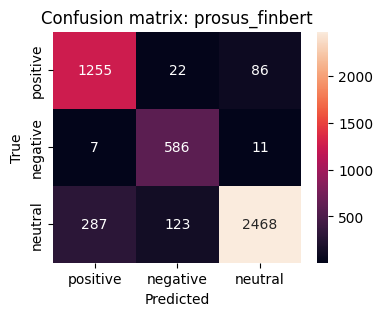

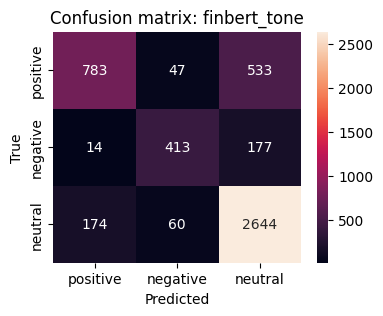

In [13]:
# Confusion matrix heatmap for each model

if any(results[r]['metrics'] for r in results):
    for name, r in results.items():
        m = r['metrics']
        if not m: continue
        cm = np.array(m['confusion_matrix'])
        fig, ax = plt.subplots(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'], ax=ax)
        ax.set_title(f'Confusion matrix: {name}')
        ax.set_xlabel('Predicted'); ax.set_ylabel('True')
        plt.show()


In [14]:
# Saved per-text predictions (for audit/trail)
# append predicted label & score to df

for name, r in results.items():
    df[f'pred_{name}'] = r['pred_labels']
    df[f'score_{name}'] = r['scores']

df.to_csv('/content/all-data-with-preds.csv', index=False)
print("Saved detailed predictions to /content/all-data-with-preds.csv")


Saved detailed predictions to /content/all-data-with-preds.csv
